# **Logistic Regression, Naive Bayes, and Support Vector Machine (SVM) using TF-IDF Vectorization**

## Import Libraries

In [1]:
#install needed libraries
!pip install wordcloud
!pip install nltk
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.1 MB/s eta 0:00:00


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import html
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter

## Data Cleaning and Preprocessing

In [3]:
#read csv file and display first 3 rows
df = pd.read_csv('/content/socialmedia-disaster-tweets-DFE[1].csv')
df.head(3)

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN


In [4]:
#display unique values in the 'choose_one' column
df['choose_one'].unique()

array(['Relevant', 'Not Relevant', "Can't Decide"], dtype=object)

In [5]:
#drop the rows where 'Can't Decide' is present because it is not relevant
df = df[df['choose_one'] != "Can't Decide"]

In [6]:
#verify the rows were dropped successfully
df['choose_one'].unique()

array(['Relevant', 'Not Relevant'], dtype=object)

In [7]:
#from the original data frame choose the relevant columns for the analysis
df = df[['choose_one','text']]
df.head()

,choose_one,text
0,Relevant,Just happened a terrible car crash
1,Relevant,Our Deeds are the Reason of this #earthquake M...
2,Relevant,"Heard about #earthquake is different cities, s..."
3,Relevant,"there is a forest fire at spot pond, geese are..."
4,Relevant,Forest fire near La Ronge Sask. Canada


In [11]:
#download stopwords and wordnet for stop word removal and lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

#set stop_words
stop_words = set(stopwords.words('english'))
#add additional stop words that are present in the data frame
stop_words.add('like')
stop_words.add('amp')
stop_words.add('www')
stop_words.add('http')
stop_words.add('https')
stop_words.add('com')

#initalize lemmatizer
lem = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [12]:
#Create a definition for data cleaning that will be called later

def clean_text(df):
    #fill in any missing values
    df['text'] = df['text'].fillna('unknown')

    #decode HTML entities
    df['text'] = df['text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

    #convert text to lowercase
    df['text'] = df['text'].str.lower()

    #remove mentions, hashtags, URLs, and any other special characters that could be found in tweets
    df['text'] = df['text'].str.replace(r'@\w+|#|http\S+|www\S+|https\S+', '', regex=True)
    df['text'] = df['text'].str.replace(r'[^a-z\s]', '', regex=True)  #keep only letters and spaces

    #remove leading/trailing whitespace
    df['text'] = df['text'].str.strip()

    #expand contractions (e.g. "don't" → "do not")
    df['text'] = df['text'].apply(lambda x: contractions.fix(x))

    #create definition for tokenization, stopword removal, and lemmatization
    def preprocess_text(text):
        words = word_tokenize(text)  #tokenize
        words = [word for word in words if word not in stop_words]  #remove stopwords
        words = [lem.lemmatize(word) for word in words if len(word) > 2]  #lemmatization and remove short words
        return " ".join(words)

    #apply the preprocess_text def to the text column
    df['text'] = df['text'].apply(preprocess_text)


    #one-hot encoding for 'choose_one' column
    if 'choose_one' in df.columns:
        df['choose_one'] = df['choose_one'].replace({"Relevant": 1, "Not Relevant": 0})

    return df

In [13]:
#apply the clean_text def to the data frame
df = clean_text(df)
df.head()

<ipython-input-12-23411a3870f5>:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['choose_one'] = df['choose_one'].replace({"Relevant": 1, "Not Relevant": 0})


,choose_one,text
0,1,happened terrible car crash
1,1,deed reason earthquake may allah forgive
2,1,heard earthquake different city stay safe ever...
3,1,forest fire spot pond goose fleeing across str...
4,1,forest fire near ronge sask canada


### Visualize the data

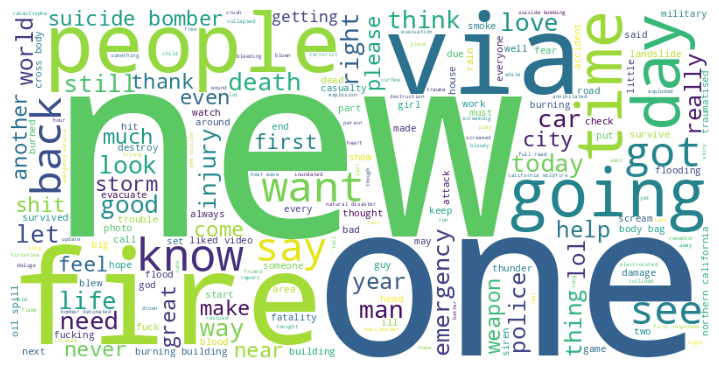

In [14]:
#create a word cloud

#combine all text data into a single string
all_text = " ".join(df['text'].tolist())

#create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

#display the word cloud
plt.figure(figsize=(7, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

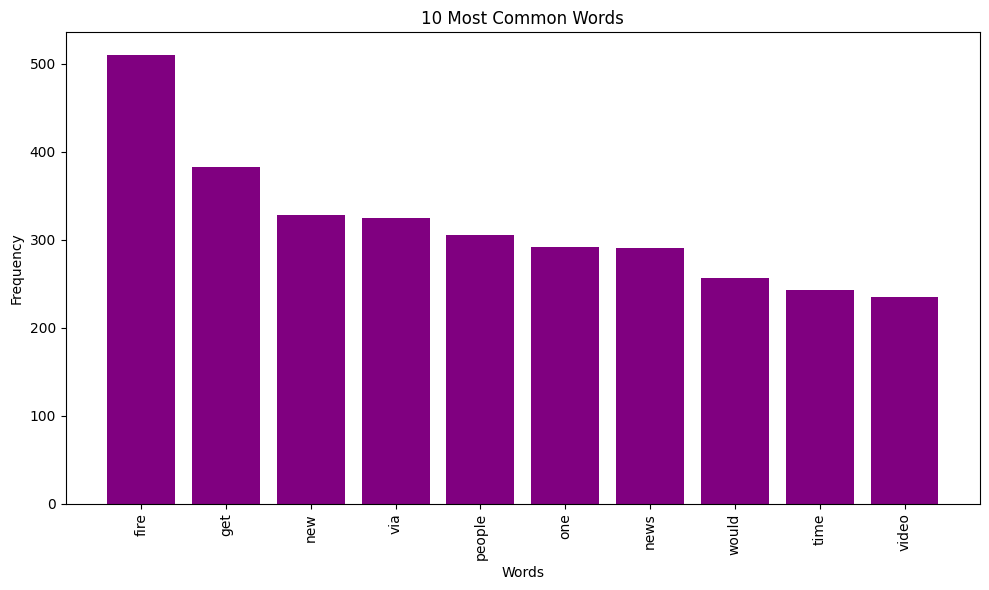

In [15]:
#create a bar chart to display top 10 words

#split the text into words
words = all_text.split()

#count word frequencies
word_counts = Counter(words)

#get the 10 most common words
most_common_words = word_counts.most_common(10)

#separate words and counts for plotting
word, count = zip(*most_common_words)

#create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(word, count, color ='purple')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("10 Most Common Words")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Model Building and Training

In [16]:
#split data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['choose_one'], test_size=0.2, random_state=42)

In [17]:
#use tf-idf for this approach
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

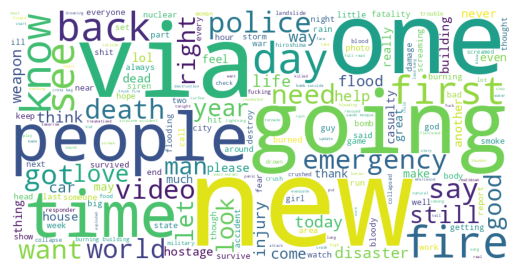

In [20]:
#Create word cloud for X_train data

#join the inner lists first
x_train_text = " ".join([" ".join(doc) for doc in vectorizer.inverse_transform(X_train_tfidf)])

#create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(x_train_text)

#display the word cloud
plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

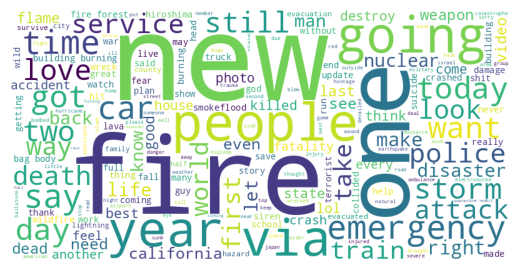

In [21]:
#Create word cloud for X_test data

#join the inner lists first
x_test_text = " ".join([" ".join(doc) for doc in vectorizer.inverse_transform(X_test_tfidf)])

#create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(x_test_text)

#display the word cloud
plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [25]:
#define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(kernel='linear')

}

#create empty results dictionary to store eval. metric results
results = {"Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

#iterate through each model through training/ testing, each eval metric, and appending the results dictionary
for name, model in models.items():
    #train model
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    #eval. metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #append results dictionary to store results
    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1 Score"].append(f1)

In [26]:
#convert results dictionary into a data frame
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.788214,0.811506,0.684211,0.742441
1,Naive Bayes,0.795580,0.824475,0.688338,0.750281
2,Support Vector Machine,0.787753,0.796729,0.703818,0.747397


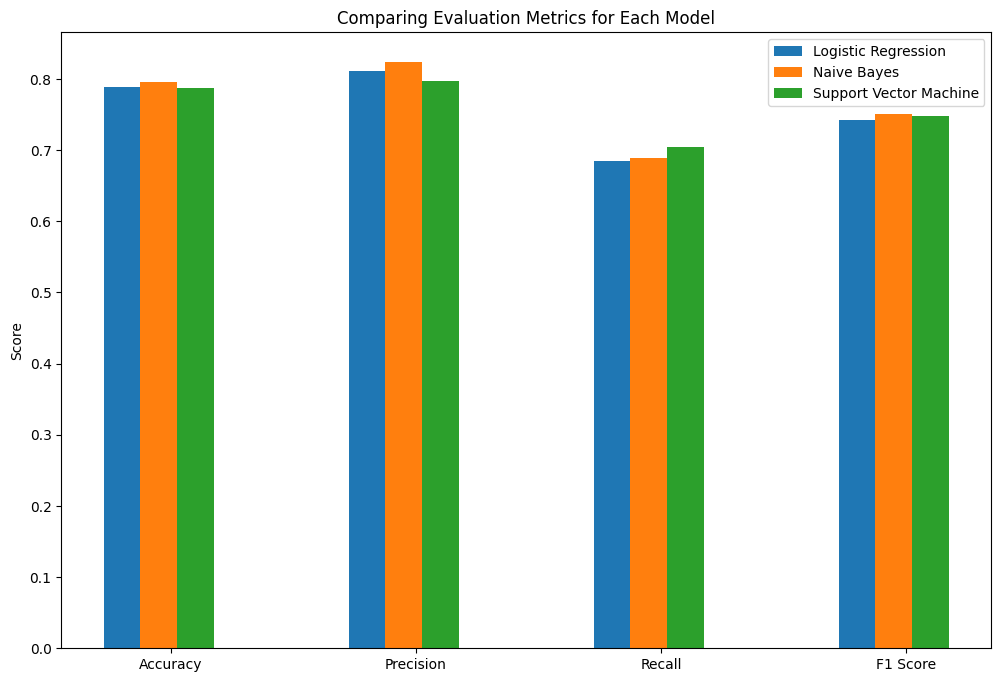

In [27]:
#Create a bar graph to display eval. metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = results_df['Model'].values

x = range(len(metrics))

fig, ax = plt.subplots(figsize=(12, 8))

width = 0.15  #set bar width for better visualization
offset = -0.2  #offset to center bars, also for better visualization

#iterate through each model and metric
for i, model in enumerate(models):
    ax.bar([xi + offset + i * width for xi in x], results_df[metrics].iloc[i].values, width=width, label=model)

#display the graph
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_title("Comparing Evaluation Metrics for Each Model")
ax.legend()
plt.show()
